In [1]:
# Standard Libraries
import argparse
import os
import sys
from tqdm import tqdm

# Python Modules
from collections import Counter
from dataclasses import dataclass
from typing import NamedTuple
from collections import namedtuple
import gc

# Type Hint Libraries
from typing import Optional, Tuple, Union, TypeVar, List
import numpy.typing as npt
import matplotlib.figure
from torch import Tensor

# Math and Data Science Libraries
import numpy as np
import pandas as pd
from scipy.ndimage.filters import convolve

# Plot Libraries
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton

# Machine Learning Libraries
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader


# Image Libraries
import cv2

import skimage as ski
from skimage import io
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
from skimage.color import hsv2rgb

# User defined methods and classes
sys.path.insert(0,'/content/drive/MyDrive/')

<ipython-input-1-a738c95dbd0d>:23: DeprecationWarning: Please use `convolve` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import convolve


In [2]:
from utils import parse_line
from utils import lines_to_polygons
from utils import build_mask_dataset
from utils import mask_in_set
from utils import nodes_to_points
from utils import plot_image_and_mask
from utils import create_binary_mask

from Unet_model import UNET

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
# Path to dataset
DATA_PATH = '/content/drive/MyDrive/PNG/'
# Creating a path to save masks
MASKS_PATH = '/content/drive/MyDrive/masks/'
# Creating a path to save model
MODEL_PATH = '/content/drive/MyDrive/model/unet_weigths_v8.pth'

In [5]:
# Creates a list of the *.png file names in the dataset
image_files = os.listdir(DATA_PATH)

In [6]:
image_names = []

for file_name in image_files:
    image_names.append(file_name.replace('.png',''))

In [7]:
print(len(image_names))
image_names = image_names[:1501]

1705


In [8]:
train_image_names, test_image_names, _, _ = train_test_split(image_names, image_names, test_size=0.2, random_state=42)

In [9]:
train_images = []
test_images = []
train_masks = []
test_masks = []

In [10]:
# Loading train images as grayscale images
for name in train_image_names:
    full_path = DATA_PATH + name + '.png'
    curr_image = io.imread(full_path)
    train_images.append(rgb2gray(curr_image))

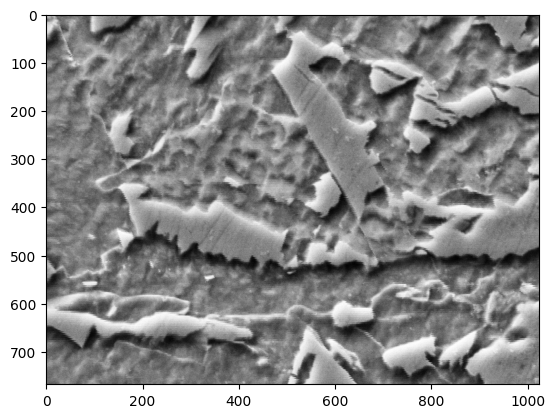

In [11]:
# Testing images were loaded correctly
plt.imshow(train_images[0], cmap=plt.cm.gray)
plt.show()

In [12]:
print('Image shape:         ',train_images[0].shape)
print('Element type:        ',train_images[0].dtype)
print('Data structure type: ',type(train_images[0]))
print('Max. value:          ',np.max(train_images[0]))
print('Min. value:          ',np.min(train_images[0]))
print('Length images:       ',len(train_images))

Image shape:          (768, 1024)
Element type:         float64
Data structure type:  <class 'numpy.ndarray'>
Max. value:           0.996078431372549
Min. value:           0.01568627450980392
Length images:        1200


In [13]:
# Loading train masks as grayscale images
for name in train_image_names:
    full_path = MASKS_PATH + name + '.jpg'
    curr_mask = io.imread(full_path)
    train_masks.append(rgb2gray(curr_mask).round())

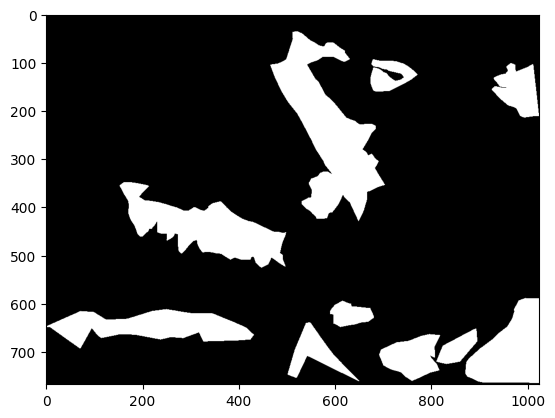

In [14]:
# Testing images were loaded correctly
plt.imshow(train_masks[0], cmap=plt.cm.gray)
plt.show()

In [15]:
print('Image shape:         ',train_masks[0].shape)
print('Element type:        ',train_masks[0].dtype)
print('Data structure type: ',type(train_masks[0]))
print('Max. value:          ',np.max(train_masks[0]))
print('Min. value:          ',np.min(train_masks[0]))
print('Length masks:        ',len(train_masks))

Image shape:          (768, 1024)
Element type:         float64
Data structure type:  <class 'numpy.ndarray'>
Max. value:           1.0
Min. value:           0.0
Length masks:         1200


In [16]:
# Loading test images as grayscale images
for name in test_image_names:
    full_path = DATA_PATH + name + '.png'
    curr_image = io.imread(full_path)
    test_images.append(rgb2gray(curr_image))

In [17]:
# Loading test images as grayscale images
for name in test_image_names:
    full_path = MASKS_PATH + name + '.jpg'
    curr_mask = io.imread(full_path)
    test_masks.append(rgb2gray(curr_mask).round())

First I created a custom Dataset class for this particular dataset:

In [18]:
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, images: list, masks: list):
        super(DataLoaderSegmentation, self).__init__()
        assert len(images) == len(masks), 'Length of image list must be the same of masks list'
        self.img = np.array(images)
        self.msk = np.array(masks)

    def __getitem__(self, index)->Tuple[Tensor]:
            data = self.img[index]
            label = self.msk[index]
            return torch.unsqueeze(torch.from_numpy(data).float(),0), torch.unsqueeze(torch.from_numpy(label).float(),0)

    def __len__(self):
        return len(self.img)

In [19]:
train_dataset = DataLoaderSegmentation(train_images,train_masks)
test_dataset = DataLoaderSegmentation(test_images,test_masks)

Next step is creating a dataloader for the network

In [20]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

Model

In [21]:
# Hyperparameters etc.
LEARNING_RATE = 1e-4                                          # Paper uses lr=2e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # Paper uses 20
NUM_EPOCHS = 3                                                # Paper uses 1e10 if
NUM_WORKERS = 2                                               # paper uses 0
IMAGE_HEIGHT = 768
IMAGE_WIDTH = 1024
PIN_MEMORY = True
LOAD_MODEL = False
loss_fn = torch.nn.BCEWithLogitsLoss()                        # Paper uses losses.DiceBCELoss(weight=0.7)
scaler = torch.cuda.amp.GradScaler()
model = UNET().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)  # Paper uses Adam
# metrics = [smp.utils.metrics.IoU(threshold=0.5),]           # Coming from the paper

In [22]:
def train_loop(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    loop = tqdm(dataloader)

    loss_20_batches = 0
    loss_epoch = 0

    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()

    for batch, (image, mask) in enumerate(loop):

        image = image.to(DEVICE)
        mask = mask.to(DEVICE)

        with torch.cuda.amp.autocast(): # Mod
            # Compute prediction and loss
            pred = model(image)
            loss = loss_fn(pred, mask)
            loss_20_batches += loss
            loss_epoch += loss

        # Backpropagation Mod
        optimizer.zero_grad()         # Original 1: loss.backward()
        scaler.scale(loss.to(DEVICE)).backward() # Original 2: optimizer.step()
        scaler.step(optimizer)        # Original 3: optimizer.zero_grad()
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

        if batch % 20 == 0:
            loop.set_postfix(loss_20_batches=loss_20_batches.item()/20)
            loss_20_batches = 0

    print(f"==> training_loss: {loss_epoch/len(dataloader):2f}")

In [23]:
def test_loop(dataloader, model, loss_fn):

    num_correct = 0
    num_pixels = 0
    dice_score = 0
    loss_epoch = 0

    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()

    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True

    with torch.no_grad():
        for batch, (image, mask) in enumerate(dataloader):

            image = image.to(DEVICE)
            mask = mask.to(DEVICE)

            pred = model(image)

            loss_epoch += loss_fn(pred, mask)
            mask_pred = torch.sigmoid(pred)
            mask_pred = (mask_pred > 0.5).float()

            num_correct += (mask_pred == mask).sum()
            num_pixels += torch.numel(mask_pred)
            dice_score += (2 * (mask_pred * mask).sum()) / (
                    (mask_pred + mask).sum() + 1e-8
            )

    print(
        f"Got {num_correct}/{num_pixels} with acc {(num_correct/num_pixels)*100:.2f}"
    )
    print(
        f"==> valuation_loss: {loss_epoch/len(dataloader):2f}"
    )

    print(f"==> dice_score: {dice_score/len(dataloader)}")

    model.train()

In [24]:
DEVICE

'cuda'

In [25]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 75/75 [01:30<00:00,  1.21s/it, loss=0.418]


==> training_loss: 0.498227
Got 217817869/236716032 with acc 92.02
==> valuation_loss: 0.425246
==> dice_score: 0.006252018269151449
Epoch 2
-------------------------------


100%|██████████| 75/75 [01:59<00:00,  1.59s/it, loss=0.368]


==> training_loss: 0.400539
Got 218347416/236716032 with acc 92.24
==> valuation_loss: 0.388060
==> dice_score: 0.0017809058772400022
Epoch 3
-------------------------------


100%|██████████| 75/75 [01:58<00:00,  1.59s/it, loss=0.337]


==> training_loss: 0.357981
Got 218267322/236716032 with acc 92.21
==> valuation_loss: 0.355224
==> dice_score: 0.06565947830677032
Epoch 4
-------------------------------


100%|██████████| 75/75 [01:58<00:00,  1.59s/it, loss=0.296]


==> training_loss: 0.322831
Got 218612627/236716032 with acc 92.35
==> valuation_loss: 0.317365
==> dice_score: 0.3179914057254791
Epoch 5
-------------------------------


100%|██████████| 75/75 [01:58<00:00,  1.59s/it, loss=0.282]


==> training_loss: 0.292719
Got 219738786/236716032 with acc 92.83
==> valuation_loss: 0.291350
==> dice_score: 0.39222782850265503
Epoch 6
-------------------------------


100%|██████████| 75/75 [01:58<00:00,  1.59s/it, loss=0.256]


==> training_loss: 0.263458
Got 215787450/236716032 with acc 91.16
==> valuation_loss: 0.279428
==> dice_score: 0.41662880778312683
Epoch 7
-------------------------------


100%|██████████| 75/75 [01:58<00:00,  1.59s/it, loss=0.224]


==> training_loss: 0.243095
Got 221173567/236716032 with acc 93.43
==> valuation_loss: 0.243554
==> dice_score: 0.45535197854042053
Epoch 8
-------------------------------


100%|██████████| 75/75 [01:58<00:00,  1.59s/it, loss=0.206]


==> training_loss: 0.227207
Got 221082926/236716032 with acc 93.40
==> valuation_loss: 0.233813
==> dice_score: 0.4987412095069885
Epoch 9
-------------------------------


100%|██████████| 75/75 [01:58<00:00,  1.59s/it, loss=0.203]


==> training_loss: 0.213085
Got 220518598/236716032 with acc 93.16
==> valuation_loss: 0.216223
==> dice_score: 0.5201513171195984
Epoch 10
-------------------------------


100%|██████████| 75/75 [01:58<00:00,  1.59s/it, loss=0.203]


==> training_loss: 0.198514
Got 221621719/236716032 with acc 93.62
==> valuation_loss: 0.202124
==> dice_score: 0.5519439578056335
Done!


In [26]:
torch.save(model.state_dict(), MODEL_PATH)

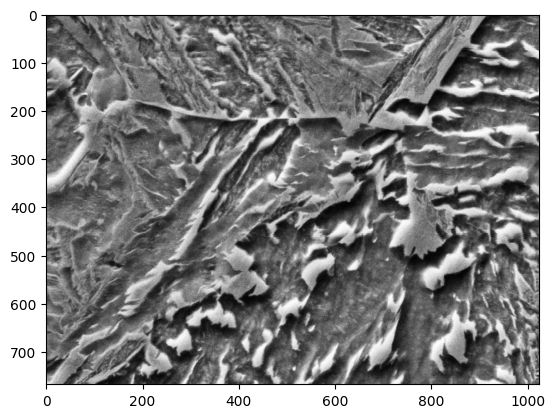

In [27]:
# Testing images were loaded correctly
plt.imshow(train_images[11], cmap=plt.cm.gray)
plt.show()

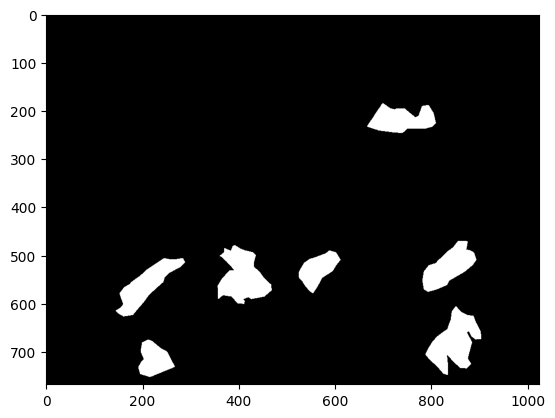

In [28]:
# Testing images were loaded correctly
plt.imshow(train_masks[11], cmap=plt.cm.gray)
plt.show()

In [29]:
test_im = train_masks[11]
test_im = torch.tensor(test_im).unsqueeze(dim=0).unsqueeze(dim=0).float()
test_im.shape

torch.Size([1, 1, 768, 1024])

In [30]:
pred = model(test_im.to(DEVICE))

In [31]:
pred.shape

torch.Size([1, 1, 768, 1024])

In [32]:
mask_pred = torch.sigmoid(pred)
mask_pred = (mask_pred > 0.5).float()

In [33]:
a = Tensor.cpu(pred.squeeze(dim=0).squeeze(dim=0)).detach().numpy()
a

array([[-2.7867734, -3.35659  , -3.4429371, ..., -3.4034035, -3.505281 ,
        -3.4499803],
       [-2.6296406, -3.1264734, -3.100715 , ..., -3.150129 , -3.0431023,
        -3.3744962],
       [-2.583745 , -3.148354 , -3.1385777, ..., -3.1836197, -3.189041 ,
        -3.496338 ],
       ...,
       [-2.5553622, -3.138239 , -3.0356643, ..., -3.2569568, -3.0880566,
        -3.5151885],
       [-2.4824803, -2.9280229, -2.9586685, ..., -3.142878 , -3.0463536,
        -3.3859987],
       [-2.014019 , -2.2759655, -2.313673 , ..., -2.4119833, -2.3904943,
        -2.7778637]], dtype=float32)

In [34]:
b = Tensor.cpu(mask_pred.squeeze(dim=0).squeeze(dim=0)).detach().numpy()
b

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

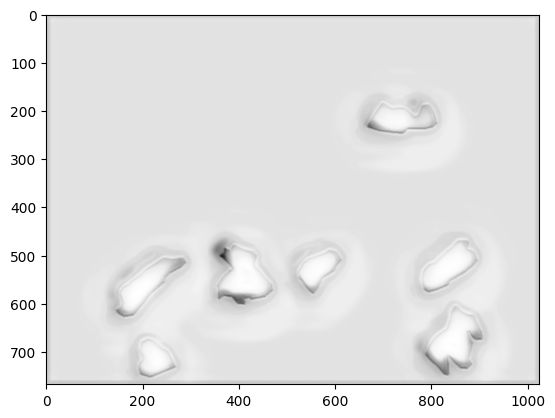

In [35]:
# Visualizing predicted mask
plt.imshow(a, cmap=plt.cm.gray)
plt.show()

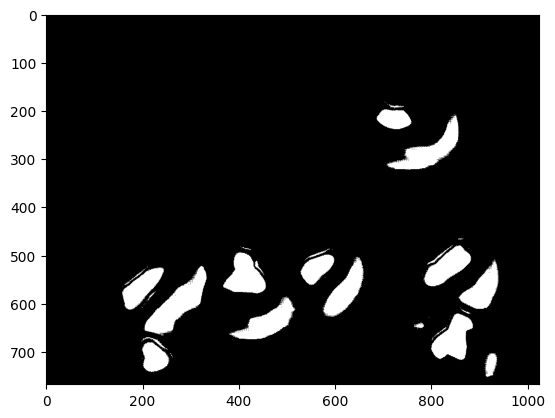

In [36]:
# Visualizing predicted mask
plt.imshow(b, cmap=plt.cm.gray)
plt.show()